In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import time
import sys
from PIL import Image
from tqdm import tqdm

In [2]:
GENERATE_RES = 4 # Generation resolution factor 
# (1=32, 2=64, 3=96, 4=128, etc.)
GENERATE_SQUARE = 32 * GENERATE_RES
IMAGE_CHANNELS = 3

# Preview image 
PREVIEW_ROWS = 1
PREVIEW_COLS = 7
PREVIEW_MARGIN = 16

# Size vector to generate images from
SEED_SIZE = 100

# Configuration
DATA_PATH = '/home/ksiva/datasets/celeba'
EPOCHS = 50
BATCH_SIZE = 32
BUFFER_SIZE = 60000

print(f"Will generate {GENERATE_SQUARE}px square images.")

Will generate 128px square images.


In [3]:
training_binary_path = os.path.join(DATA_PATH, f'training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}.npy')

print(f"Looking for file: {training_binary_path}")

if not os.path.isfile(training_binary_path):
    start = time.time()
    print('Loading training images...')
    
    training_data = []
    faces_path = os.path.join(DATA_PATH, 'celeba_hq_256_jpeg')
    for filename in tqdm(os.listdir(faces_path)):
      path = os.path.join(faces_path, filename)
      image = Image.open(path).resize((GENERATE_SQUARE, GENERATE_SQUARE), Image.LANCZOS)
      training_data.append(np.asarray(image))

    start_reshape = time.time()
    print('Reshaping data...')
    training_data = np.reshape(training_data,(-1, GENERATE_SQUARE, GENERATE_SQUARE, IMAGE_CHANNELS))
    print(f'Reshaping is complete! Processing time: {time.time() - start_reshape:.1f}s')

    start_dtype = time.time()
    print('Normalizing data...')
    training_data = training_data.astype(np.float32)
    training_data = training_data / 127.5 - 1.
    print(f'Settings is complete! Processing time: {time.time() - start_dtype:.1f}s')
    print(f'Data size: {sys.getsizeof(training_data) / 1e6:.1f}MB')

    print("Saving training image binary...")
    np.save(training_binary_path, training_data)
    print (f'Image preprocess time: {time.time() - start:.1f}s')
    
else:
    print('Loading previous training pickle...')
    training_data = np.load(training_binary_path)

Looking for file: /home/ksiva/datasets/celeba/training_data_128_128.npy
Loading previous training pickle...


In [4]:
train_dataset = tf.data.Dataset.from_tensor_slices(training_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [5]:
def build_generator(seed_size, channels):
    return Sequential(
        [
            Input((seed_size,)),
            Dense(4*4*256, activation='relu'),
            Reshape((4,4,256)),
            
            UpSampling2D(),
            Conv2D(256, kernel_size=3, padding='same'),
            BatchNormalization(momentum=0.8),
            Activation('relu'),

            UpSampling2D(),
            Conv2D(256, kernel_size=3, padding='same'),
            BatchNormalization(momentum=0.8),
            Activation('relu'),

            UpSampling2D(),
            Conv2D(128, kernel_size=3, padding='same'),
            BatchNormalization(momentum=0.8),
            Activation('relu'),

            UpSampling2D(size=(GENERATE_RES, GENERATE_RES)),
            Conv2D(128, kernel_size=3, padding='same'),
            BatchNormalization(momentum=0.8),
            Activation('relu'),

            Conv2D(channels, kernel_size=3, padding='same'),
            Activation('tanh')
        ]
    )


def build_discriminator(image_shape):
    return Sequential(
        [
            Input(image_shape),
            Conv2D(32, kernel_size=3, strides=2, padding='same'),
            LeakyReLU(negative_slope=0.2),

            Dropout(0.25),
            Conv2D(64, kernel_size=3, strides=2, padding='same'),
            ZeroPadding2D(padding=((0,1), (0,1))),
            BatchNormalization(momentum=0.8),
            LeakyReLU(negative_slope=0.2),

            Dropout(0.25),
            Conv2D(128, kernel_size=3, strides=2, padding='same'),
            BatchNormalization(momentum=0.8),
            LeakyReLU(negative_slope=0.2),

            Dropout(0.25),
            Conv2D(256, kernel_size=3, strides=1, padding='same'),
            BatchNormalization(momentum=0.8),
            LeakyReLU(negative_slope=0.2),

            Dropout(0.25),
            Conv2D(512, kernel_size=3, strides=1, padding='same'),
            BatchNormalization(momentum=0.8),
            LeakyReLU(negative_slope=0.2),

            Dropout(0.25),
            Flatten(),
            Dense(1, activation='sigmoid')
        ]
    )

In [6]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [7]:
noise = tf.random.normal([1, SEED_SIZE])
image_shape = (GENERATE_SQUARE, GENERATE_SQUARE, IMAGE_CHANNELS)

In [8]:
generator = build_generator(SEED_SIZE, IMAGE_CHANNELS)
generator_optimizer = tf.keras.optimizers.Adam(1.5e-4, 0.5)

In [9]:
discriminator = build_discriminator(image_shape)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4, 0.5)

In [10]:
@tf.function
def train_step(images):
    seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(seed, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
        
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        
    return gen_loss, disc_loss

In [11]:
def train(dataset, epochs) -> tuple[list, list]:
    start = time.time()
    gen_loss_history = []
    disc_loss_history = []
    
    for epoch in range(epochs):
        epoch_start = time.time()
        
        gen_loss_list = []
        disc_loss_list = []
        
        for image_batch in dataset:
            t = train_step(image_batch)
            gen_loss_list.append(t[0])
            disc_loss_list.append(t[1])

        g_loss = sum(gen_loss_list) / len(gen_loss_list)
        d_loss = sum(disc_loss_list) / len(disc_loss_list)

        gen_loss_history.append(g_loss)
        disc_loss_history.append(d_loss)

        print(f'Epoch {epoch + 1}/{epochs}\n'\
              f'{time.time() - epoch_start:.1f}s - generator loss: {g_loss:.4f} - discriminator loss: {d_loss:.4f}')

    print(f'Training time: {time.strftime("%-Hh %-Mm %-Ss", time.gmtime(time.time() - start))}')

    return gen_loss_history, disc_loss_history

In [12]:
gen_loss_history, disc_loss_history = train(train_dataset, EPOCHS)

Epoch 1/50
161.1s - generator loss: 4.2281 - discriminator loss: 1.3035
Epoch 2/50
144.4s - generator loss: 3.5888 - discriminator loss: 1.2210
Epoch 3/50
144.4s - generator loss: 3.7160 - discriminator loss: 1.0503
Epoch 4/50
144.4s - generator loss: 3.7895 - discriminator loss: 0.9383
Epoch 5/50
144.5s - generator loss: 3.9858 - discriminator loss: 0.8624
Epoch 6/50
144.5s - generator loss: 4.0393 - discriminator loss: 0.8584
Epoch 7/50
144.5s - generator loss: 3.6812 - discriminator loss: 0.7973
Epoch 8/50
144.5s - generator loss: 3.7682 - discriminator loss: 0.8203
Epoch 9/50
144.4s - generator loss: 3.8664 - discriminator loss: 0.7986
Epoch 10/50
144.5s - generator loss: 3.8407 - discriminator loss: 0.7677
Epoch 11/50
144.5s - generator loss: 3.8971 - discriminator loss: 0.7582
Epoch 12/50
144.6s - generator loss: 3.9232 - discriminator loss: 0.7375
Epoch 13/50
144.0s - generator loss: 4.0852 - discriminator loss: 0.7107
Epoch 14/50
143.9s - generator loss: 4.0940 - discriminator 

In [13]:
model_training_date_time = time.localtime()

In [14]:
def convert_time(time_time, pattern: str = '%Y-%m-%d-%H-%M') -> str:
    return time.strftime(pattern, time_time)

model_training_date_time_parsed = convert_time(model_training_date_time)

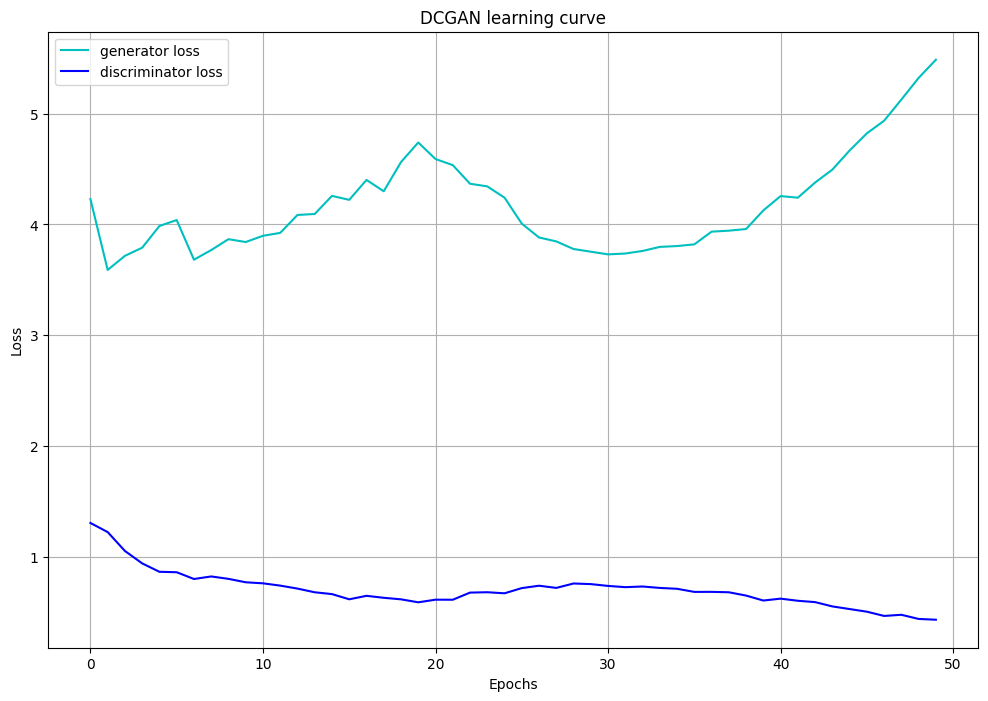

In [15]:
plt.figure(figsize=(12, 8))
plt.title('DCGAN learning curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(gen_loss_history, label='generator loss', color='c')
plt.plot(disc_loss_history, label='discriminator loss', color='b')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(DATA_PATH, f'{model_training_date_time_parsed}_learning_curve.pdf'))
plt.show()

In [16]:
generator.save(os.path.join(DATA_PATH, f'{model_training_date_time_parsed}_dcgan.keras'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 913ms/step


I0000 00:00:1708874079.518893   29381 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


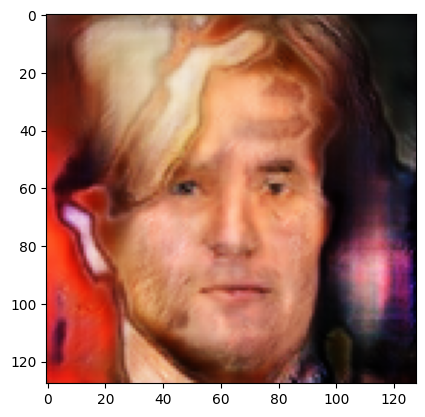

In [17]:
noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator.predict(noise)
generated_image = 0.5 * generated_image + 0.5

plt.imshow(generated_image[0])

In [28]:
def save_images(name, noise):
    image_array = np.full((
        PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)),
        PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), IMAGE_CHANNELS),
                    255, dtype=np.uint8)
  
    generated_images = generator.predict(noise)

    generated_images = 0.5 * generated_images + 0.5
    
    image_count = 0
    for row in range(PREVIEW_ROWS):
        for col in range(PREVIEW_COLS):
            r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
            c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
            image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] = generated_images[image_count] * 255
            image_count += 1

    output_path = os.path.join(DATA_PATH, 'output')
    if not os.path.exists(output_path):
        os.makedirs(output_path)
  
    filename = os.path.join(output_path,f'{name}.pdf')
    im = Image.fromarray(image_array)
    im.save(filename)

In [29]:
save_images(f'{model_training_date_time_parsed}_output', np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS, SEED_SIZE)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
